In [1]:
DGIS_API_KEY = "..." # leave a request here and you will recive a KEY https://dev.2gis.ru/order/
Yandex_API_KEY = "..." # to recive KEY fo free go here https://developer.tech.yandex.ru/services/3/

In [2]:
import pandas as pd
import numpy as np
import requests
from PIL import Image
from IPython.display import display
from io import BytesIO
from typing import Union
import pants
import matplotlib.pyplot as plt
import seaborn as sns
from python_tsp.heuristics import solve_tsp_simulated_annealing
from python_tsp.exact import solve_tsp_dynamic_programming
import pickle
import networkx as nx
from time import time

In [3]:
class Node():
    def __init__(self, address: str):
        self.address = address
        self.lon = ""
        self.lat = ""
        self._status = None
        self.time = 0
    def geocode(self):
        global Yandex_API_KEY
        geocode_url = f"https://geocode-maps.yandex.ru/1.x/?apikey={Yandex_API_KEY}&geocode={self.address.replace(' ', '%20')}&format=json"
        self.time = time()
        answer = requests.get(geocode_url).json()
        self.time = time() - self.time
        if answer['response']['GeoObjectCollection']['metaDataProperty']['GeocoderResponseMetaData']['found'] == "0":
            print(f"По запросу «{place}» ничего не найдено. Точка была убрана из рассмотрения.")
            self._status = False
            return
        self.lon = float(answer['response']['GeoObjectCollection']\
                                                  ['featureMember'][0]['GeoObject']['Point']['pos'].split()[0])
        self.lat = float(answer['response']['GeoObjectCollection']\
                                                  ['featureMember'][0]['GeoObject']['Point']['pos'].split()[1])
        self._status = True
        return
        
        
        

In [12]:
class TSP_solve():
    def __init__(self, path:list=[], distance:Union[int, float]=0, matrix:list=None, method:str="", places:list=[], coordinates=None): # сделать параметры по умолчанию
        self.path = []
        self.distance = 0
        self.matrix = None
        self.method = ""
        self.places = []
        self.nodes = []
        
        
    def bool_mask_check(mask: Union[np.ndarray, list], length: int) -> None:
        assert np.shape(mask) == (length, length), 'Размерность переданной матрицы не соответствует количеству переданных точек'
        assert sorted(np.unique(mask).astype('int').tolist()) == [0, 1], 'Маска должна состоять из булевых значений или {0, 1}'
        mat = mask.copy()
        np.fill_diagonal(mat, 0)
        G = nx.from_numpy_array(mat)
        assert nx.is_connected(G), "Граф не является связным. Измените маску."
        
    def fit(self, places:list, bool_mask: Union[np.ndarray, list]=None):
        global DGIS_API_KEY
                
        cenceled_points = []
        
        for i, place in enumerate(places):
            node = Node(place)
            node.geocode()
            if node._status:
                self.nodes.append(node)
            else:
                cenceled_points.append(i)

        if isinstance(bool_mask, (np.ndarray, list)):
            bool_mask = np.array(bool_mask)[list(set(range(len(bool_mask)))-set(cenceled_points))][:, list(set(range(len(bool_mask)))-set(cenceled_points))]
            bool_mask_check(bool_mask, len(self.nodes))
        
        self.places = np.array(places)[list(set(range(len(places))) - set(cenceled_points))].tolist()
        
        data = '{"points": ' + str([{"lat": node.lat, "lon": node.lon} for node in self.nodes]).replace("'", '"')
        data += f',"sources": {list(range(len(self.nodes)))},"targets": {list(range(len(self.nodes)))}'+'}'
        
        matrix_url = f"https://routing.api.2gis.com/get_dist_matrix?key={DGIS_API_KEY}&version=2.0"
        request =  requests.post(matrix_url, data=data)
        result = pd.DataFrame(request.json()["routes"])
        matrix = pd.pivot_table(result, values='distance', index=['source_id'], columns=['target_id']).values
        matrix = matrix.astype("float")
        
        if bool_mask:
            matrix = matrix * bool_mask
        
        matrix[matrix == 0] = np.inf
        
        self.matrix = matrix
    
    
    def output(self) -> None:
        print(f'Наилучший результат показал "{self.method}"')
        print("Оптимальный маршрут:\n"+" -> ".join(self.path))
        print("Продолжительность построенного маршрута:", self.distance)
    
    def heatmap(self) -> None:
        mat = self.matrix.copy()
        mat[mat==np.inf] = mat[mat!=np.inf].max()*1.2
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        sns.heatmap(mat, 
                    ax=ax, 
                    cmap= "Blues")
        ax.set_xticklabels(self.places, rotation=30)
        ax.set_yticklabels(self.places, rotation=30)
        plt.show()
        
    
    
    def plot_points(self) -> None:
        base_map_url = "https://static.maps.2gis.com/1.0?s=800x800"
        base_map_url += "".join([f"&pt={node.lat},{node.lon}" for node in self.nodes])
        response = requests.get(base_map_url)
        img = Image.open(BytesIO(response.content))
        display(img)
        
    def plot_trip(self):
        coords_order = sorted(self.nodes, key=lambda x: self.places.index(x.address))
        base_route_url = "https://static.maps.2gis.com/1.0?s=800x800@2x&ls="
        for i in range(len(coords_order)):
            base_route_url += f"{coords_order[i].lat},{coords_order[i].lon},"
        base_route_url += f"{coords_order[0].lat},{coords_order[0].lon}"
        for i in range(len(coords_order)):
            base_route_url += f"&pt={coords_order[i].lat},{coords_order[i].lon}~n:{i+1}"

        response = requests.get(base_route_url)
        img = Image.open(BytesIO(response.content))
        display(img)
    
    
    def Dynamic_Programming(self):
        path, distance = solve_tsp_dynamic_programming(self.matrix)
        self.path = np.asarray(self.places)[path]
        self.distance = distance
        self.method = "Метод динамического программирования"
        
    def Simulated_Annealing(self):
        matrix = self.matrix.copy()
        matrix[matrix == np.inf] = matrix[matrix != np.inf].max()*1_000_000
        path, distance = solve_tsp_simulated_annealing(matrix)
        self.path = np.array(self.places)[path]
        self.distance = distance
        self.method = "Метод Отжига"
        
    def ACO(self):
        def get_time(inn, out):
            if self.matrix[inn, out] != np.inf:
                return self.matrix[inn, out]
            return self.matrix[self.matrix != np.inf].max()*1_000_000
        world = pants.World(list(range(len(self.matrix))), get_time)
        solver = pants.Solver()
        solution = solver.solve(world)
        self.path = np.array(self.places)[solution.tour]
        self.method = "Метод муравьиной колонии"
        self.distance = solution.distance
        
    
    def fastest(self):
        methods = ["ACO", "Simulated_Annealing", "Dynamic_Programming"]
        example = TSP_solve()
        example.matrix = self.matrix
        example.places = self.places
        
        results = []
        for method in methods:
            getattr(example, method)()
            results.append({"method": method,
                            "path": example.path, 
                            "distance": example.distance, 
                            "method_full_name": example.method})
        best_method = min(results, key=lambda x: x["distance"])
        self.path = best_method["path"].tolist()
        self.distance = best_method["distance"]
        self.method = best_method["method_full_name"]

# TSP solution on a real data (russian specificity).

In [6]:
# input data should be provided in the following format.
# every string is an adress or unambiguous name of a place (like Kremlin in Moscow)
my_places = [
    "МОСКВА, КРЕМЛЬ",
    "МОСКВА, ПАРК ЗАРЯДЬЕ",
    "МОСКВА, ПАРК ГОРЬКОГО",
    "МОСКВА, ТРЕТЬЯКОВСКАЯ ГАЛЕРЕЯ",
    "МОСКВА, МГУ",
    "МОСКВА, СТАДИОН «ЛУЖНИКИ»",
    "МОСКВА, МОСКВА-СИТИ",
    "МОСКВА, МУЗЕЙ-ПАНОРАМА «БОРОДИНСКАЯ БИТВА»",
    "МОСКВА, ОСТАНКИНСКАЯ ТЕЛЕБАШНЯ",
    "МОСКВА, ВДНХ"
]

In [63]:
# create and fit our model with data
model = TSP_solve()
# while fiting the boolean mask can also be provided
# it is used to ban routes between any points
# if the matrix makes the graph not connected
# AssertionError will be raised
model.fit(my_places, bool_mask=np.random.choice([0, 1], p=[0.9, 0.1], size=((len(my_places), len(my_places)))))

AssertionError: Граф не является связным. Измените маску.

In [7]:
# Let`s fit the model with out bool mask
model = TSP_solve()
model.fit(my_places)

In [ ]:
# the key point of that work is in using a real data about the trevel time between points
# insted of distances program uses travel time by car
# that time includes traffic lights, jam etc.

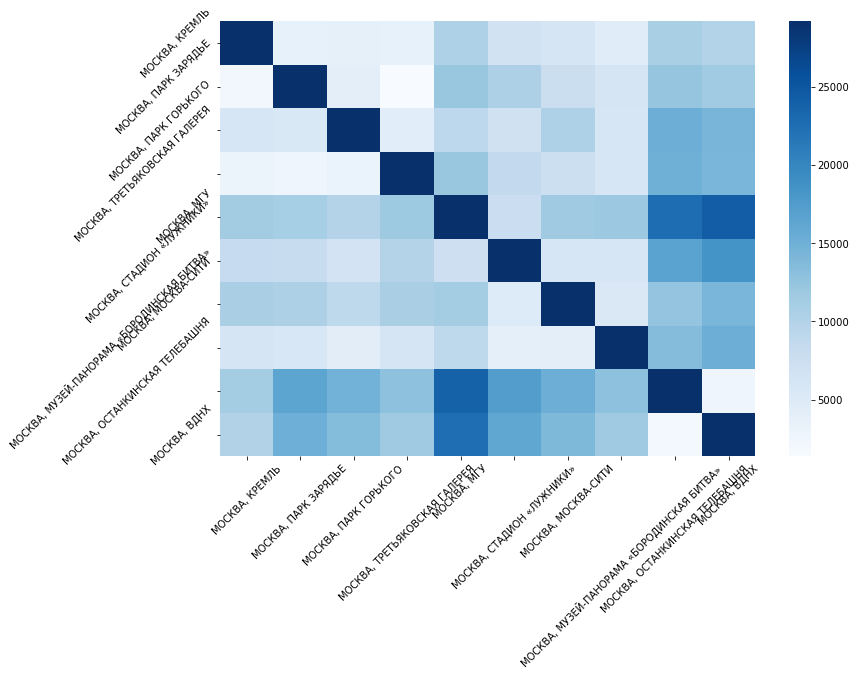

In [13]:
# the visualisation of travel time between every 2 points
model.heatmap()

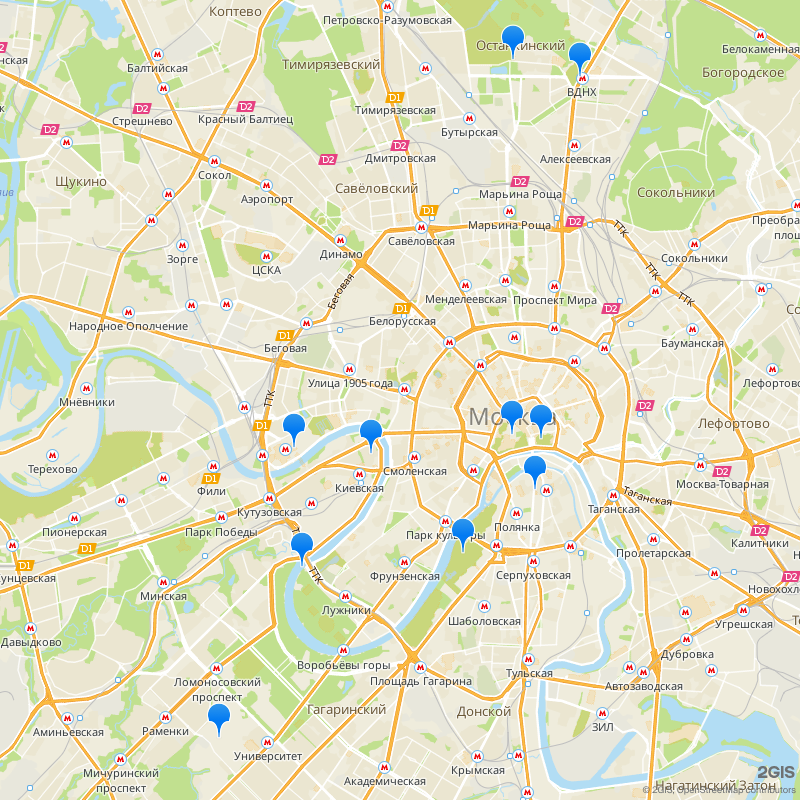

In [67]:
# points on the map
model.plot_points()

In [10]:
# now let`s find the fastest path

# for solving TSP there are several methods build in the script
# we may use any of them or ask for the fastest one
model.fastest()

In [11]:
# here is a full information about the path
model.output()

Наилучший результат показал "Метод муравьиной колонии"
Оптимальный маршрут:
МОСКВА, ОСТАНКИНСКАЯ ТЕЛЕБАШНЯ -> МОСКВА, ВДНХ -> МОСКВА, КРЕМЛЬ -> МОСКВА, ПАРК ЗАРЯДЬЕ -> МОСКВА, ТРЕТЬЯКОВСКАЯ ГАЛЕРЕЯ -> МОСКВА, ПАРК ГОРЬКОГО -> МОСКВА, МГУ -> МОСКВА, СТАДИОН «ЛУЖНИКИ» -> МОСКВА, МУЗЕЙ-ПАНОРАМА «БОРОДИНСКАЯ БИТВА» -> МОСКВА, МОСКВА-СИТИ
Продолжительность построенного маршрута: 60618.0


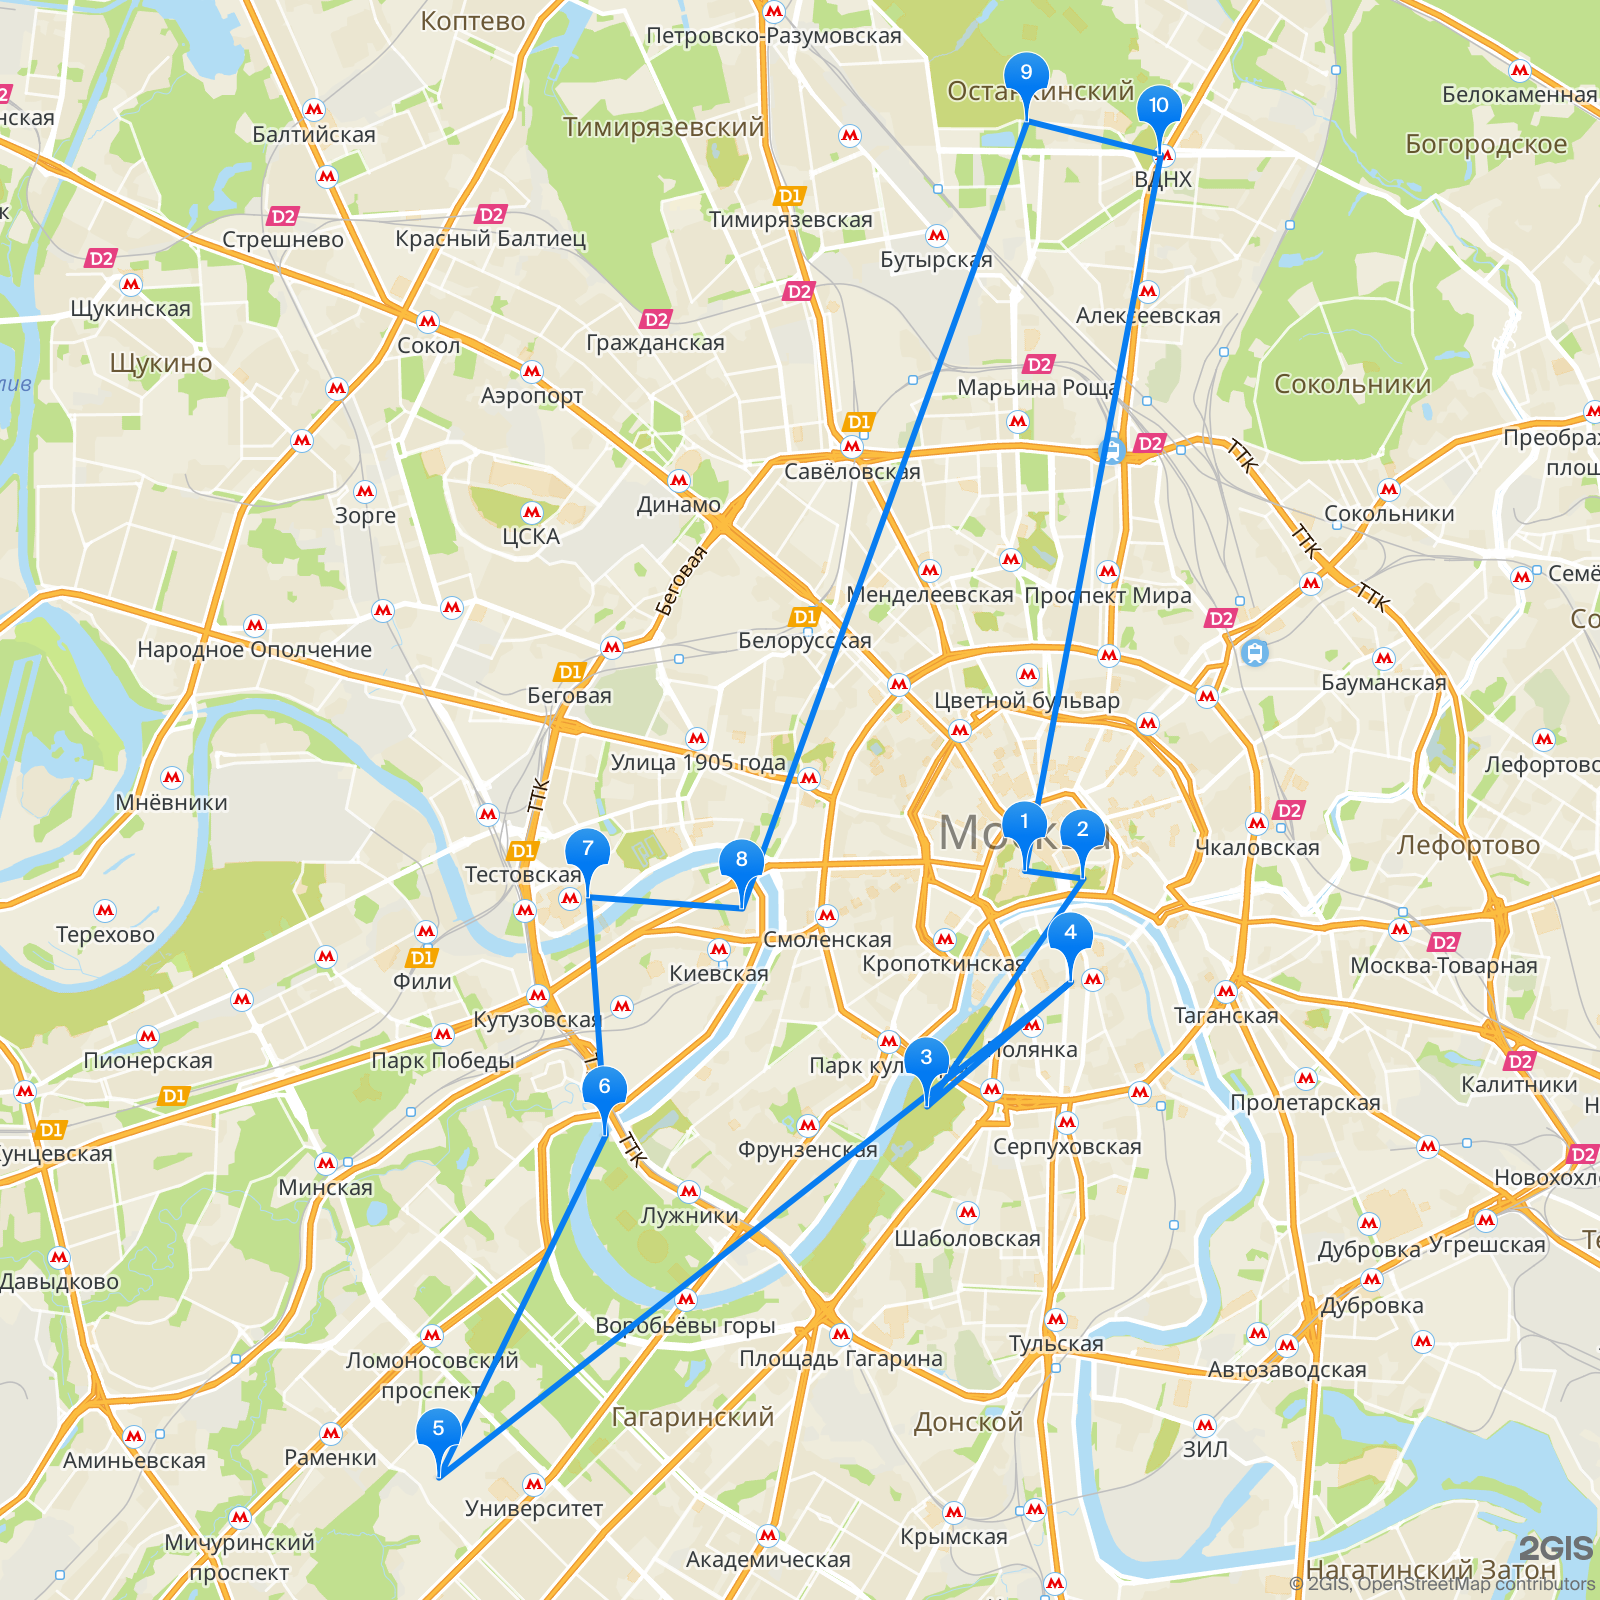

In [68]:
# unfortunately, there is no method to plot the path as it was calculated 
# for reasons of visualization points are connected by a straight line
model.plot_trip()

In [69]:
# let`s look at the points more prooperly
model.nodes

In [16]:
# every point is an object of a class
# there you can find all information abot them
model.nodes[0].address

'МОСКВА, КРЕМЛЬ'